<Figure size 720x504 with 0 Axes>

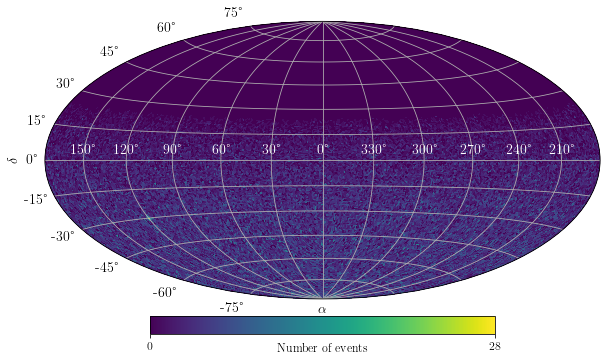

In [2]:
#---------------------------------------
# Try optimize the code!!!!
#---------------------------------------
import math
import numpy as np 
import healpy as hp
from healpy.newvisufunc import projview

#for plotting 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

#to import and work with data frames 
import pandas as pd

%matplotlib inline

rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=True)

#convert a set of pandas columns into a list of event 
def pandas_to_event(df, str1 , str2, str3, str4):
    
    alpha = df[str1].to_numpy()
    delta = df[str2].to_numpy()
    time = df[str3].to_numpy()
    energy = df[str4].to_numpy()
    
    evt_list = []
    
    for i in range(len(alpha)):
        evt_list.append([alpha[i],delta[i],time[i],energy[i]])
        
    return evt_list

#convert to healpy coordinates 
def Healpy_Event(evt_list):
        
    new_evt_list = []
    
    for evt in evt_list:
        evt[1] = math.pi/2 - evt[1]
        new_evt_list.append(evt)
    
        
    return new_evt_list

#compute the 
#-------------------------------
# main 
#-------------------------------

#save dataframe with event info from csv file
path = '/home/miguelm/Documents/Anisotropies/DataSets/MockData_Repeaters/'
filename = 'TimeOrdered_Events_ExponentialRepeater_Date_2015-01-01T00:00:00_Period_86164_TotalEvents_100000_AcceptedRepEvents_100.parquet'

uniform_dist_data = pd.read_parquet(path + filename, engine='fastparquet') 

#convert dataframe into a list of events
uniform_dist_events = pandas_to_event(uniform_dist_data,"rep_ud_ra", "rep_ud_dec","rep_ud_gpstime","rep_ud_energy")    

#change delta into colatitude to project in sky
hp_ud_events = Healpy_Event(uniform_dist_events)


#12*nside*nside gives the number of pixels of sphere 
NSIDE = 64
            
#vector with index positions in healpy sky_map given theta and phi
cr_sky_indexes = [] 

#vector to hold events. If the event is accepted, the vector is field with 1, otherwise it is filed with 0
events = []

#run over the events 
for evt in hp_ud_events:
    
    cr_sky_indexes.append(hp.ang2pix(NSIDE,evt[1],evt[0]))
    events.append(1)

#count map for each event: vector with size npix and filled with 0s
instant_cr_sky = np.zeros(hp.nside2npix(NSIDE))

#subsitutes zeros in the pixel indices for their bin content, given the data
np.add.at(instant_cr_sky, cr_sky_indexes, events)

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    instant_cr_sky,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('skymap_repeater.pdf',dpi=500)



<Figure size 720x504 with 0 Axes>

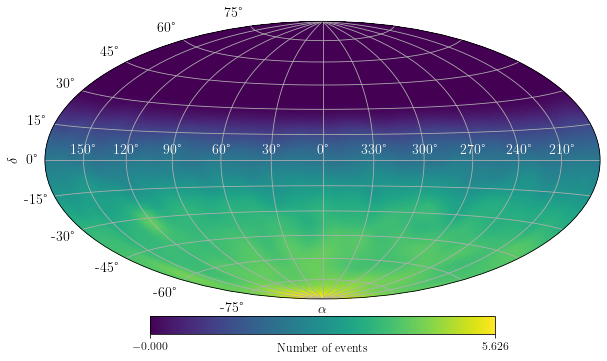

In [5]:
#isto tem de passar a ser um smooting gaussiano!!! -> VER PROCEEDINGS DA EMILY
def top_hat_beam(radius, nside):
    
    b = np.linspace(0.0, np.pi, 10000)
    bw = np.where(abs(b) <= radius, 1, 0)
    return hp.sphtfunc.beam2bl(bw, b, lmax=3*nside) #beam in the spherical harmonics space

def ProduceSmoothedMap(count_map, radius_deg, nside):
    
    radius = np.radians(radius_deg)
    solid_angle = 2.*np.pi*(1. - np.cos(radius))
    return hp.smoothing(count_map, beam_window=top_hat_beam(radius, nside)) / solid_angle

smoothing_radius = np.radians(10)

#smooth_sky_map = ProduceSmoothedMap(instant_cr_sky, smoothing_radius,NSIDE)

smooth_sky_map = hp.smoothing(instant_cr_sky, sigma=0.5*smoothing_radius)
#create figure
fig_smooth = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    smooth_sky_map,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('smooth_sky_map_repeater.pdf',dpi=500)